## Qiskit Circuit Library and Quantum Info Demo

We take a brief tour of the `qiskit.circuit.library` and the `qiskit.quantum_info` modules through examples.

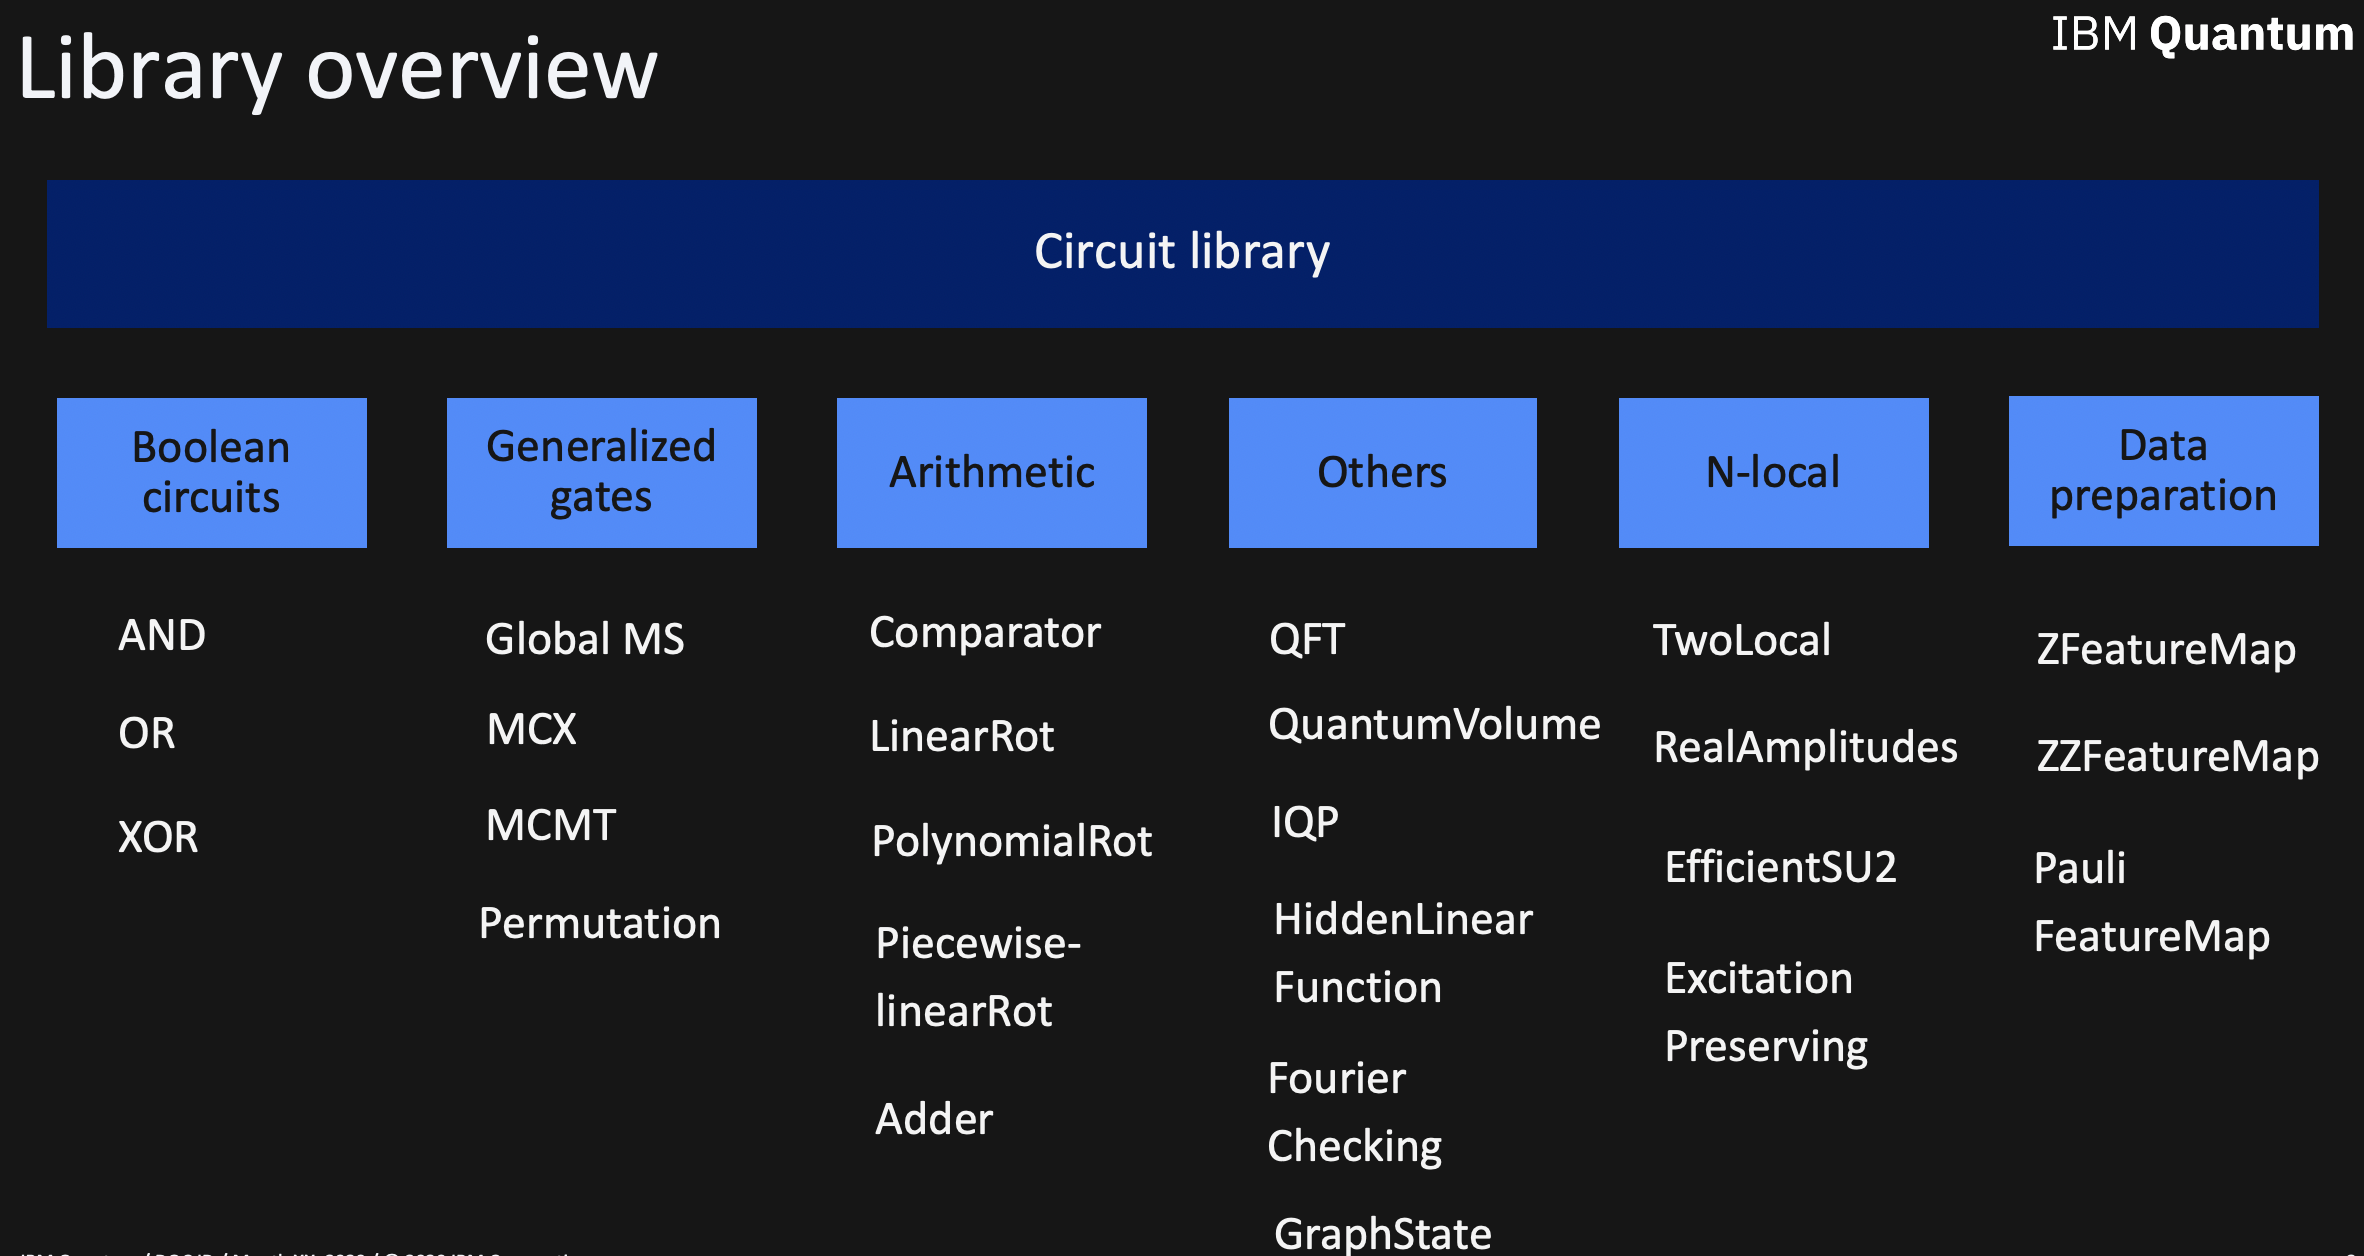

### Quantum vs. Classical Libraries

Quantum circuits can be used to compute functions, just like classical library calls. A good example of this is Fourier transform which is exponentially faster on a quantum computer. It was discovered at IBM Research [1]. We further show how circuits can be combined with each other as building blocks to build more complex transformations, such as the Hartley transform [2]. We will use the quantum_info module to analyze each of these, and will discuss how circuits can be optimized and offered as a service. Lastly we discuss how Qiskit Aqua can natively work with this library.

[1] [D. Coppersmith, An approximate Fourier transform useful in quantum factoring, 1994](https://arxiv.org/abs/quant-ph/0201067)

[2] [A. Klappenecker, M. Roettler, Quantum Software Reusability, 2003](https://arxiv.org/abs/quant-ph/0309121)

In [1]:
def plot_classical_vs_quantum(classical, quantum):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    width = 0.5

    ax[0].bar(np.arange(0, 2**num_qubits)-width/2, np.real(classical), width)
    ax[0].bar(np.arange(0, 2**num_qubits)+width/2, np.real(quantum), width)
    ax[0].set_title('real')
    ax[0].legend(['classical', 'quantum'])

    ax[1].bar(np.arange(0, 2**num_qubits)-width/2, np.imag(classical), width)
    ax[1].bar(np.arange(0, 2**num_qubits)+width/2, np.imag(quantum), width)
    ax[1].set_title('imaginary')
    ax[1].legend(['classical', 'quantum'])

    return fig   # utility plotting function

### Example 1: Fourier Transform

In [2]:
import numpy as np
import qiskit as qk
import qiskit.quantum_info as qi

num_qubits = 6
qft = qk.circuit.library.QFT(num_qubits, insert_barriers=True)
qft.draw(fold=200)

░                                    ░                            ░                     ░              ░ ┌───┐ ░          
q_0: ───────────────────────────────────■───────░────────────────────────────■───────░─────────────────────■──────░──────────────■──────░───────■──────░─┤ H ├─░──X───────
                                        │       ░                            │       ░                     │      ░              │      ░ ┌───┐ │pi/2  ░ └───┘ ░  │       
q_1: ───────────────────────────■───────┼───────░─────────────────────■──────┼───────░──────────────■──────┼──────░───────■──────┼──────░─┤ H ├─■──────░───────░──┼──X────
                                │       │       ░                     │      │       ░              │      │      ░ ┌───┐ │pi/2  │pi/4  ░ └───┘        ░       ░  │  │    
q_2: ────────────────────■──────┼───────┼───────░──────────────■──────┼──────┼───────░───────■──────┼──────┼──────░─┤ H ├─■──────■──────░──────────────░───────░──┼──┼──X─
                         │      │       │       ░              │      │      │       ░ ┌───┐ │pi/2  │pi/4  │pi/8  ░ └───┘               ░              ░       ░  │  │  │ 
q_3: ─────────────■──────┼──────┼───────┼───────░───────■──────┼──────┼──────┼───────░─┤ H ├─■──────■──────■──────░─────────────────────░──────────────░───────░──┼──┼──X─
                  │      │      │       │       ░ ┌───┐ │pi/2  │pi/4  │pi/8  │pi/16  ░ └───┘                      ░                     ░              ░       ░  │  │    
q_4: ──────■──────┼──────┼──────┼───────┼───────░─┤ H ├─■──────■──────■──────■───────░────────────────────────────░─────────────────────░──────────────░───────░──┼──X────
     ┌───┐ │pi/2  │pi/4  │pi/8  │pi/16  │pi/32  ░ └───┘                              ░                            ░                     ░              ░       ░  │       
q_5: ┤ H ├─■──────■──────■──────■───────■───────░────────────────────────────────────░────────────────────────────░─────────────────────░──────────────░───────░──X───────
     └───┘                                      ░                                    ░                            ░                     ░              ░       ░

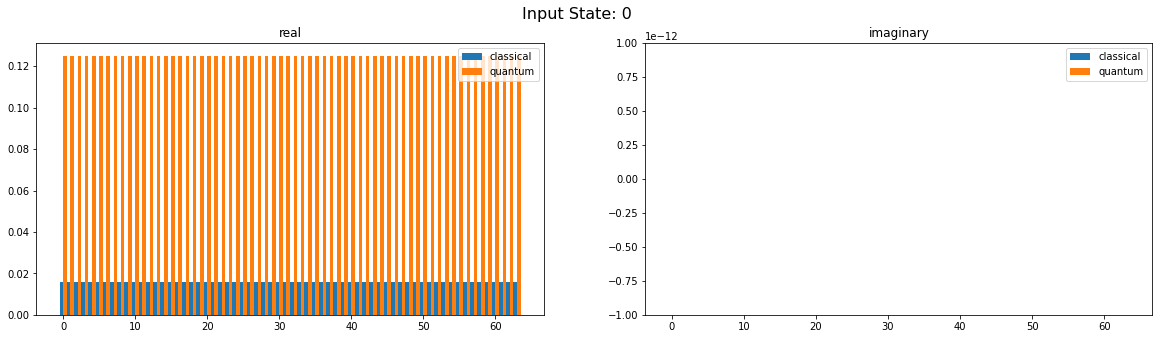

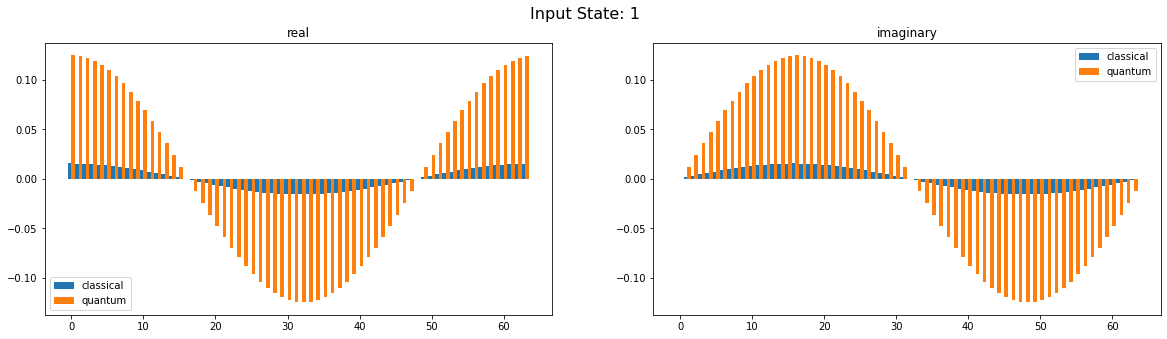

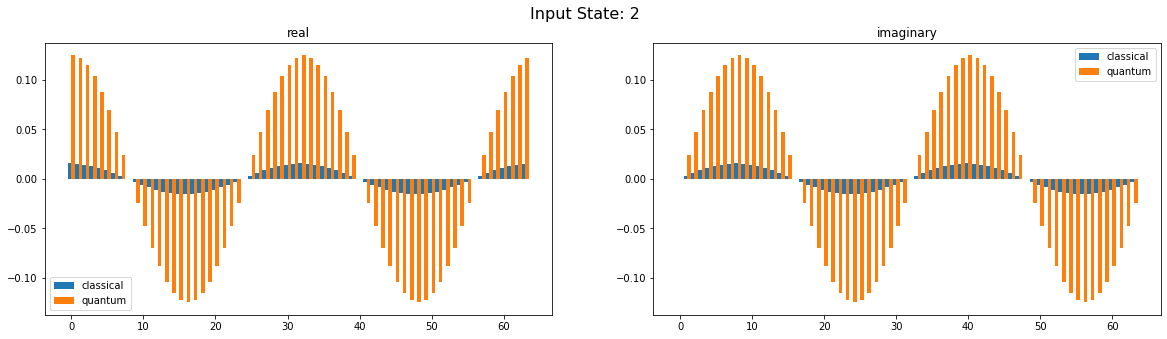

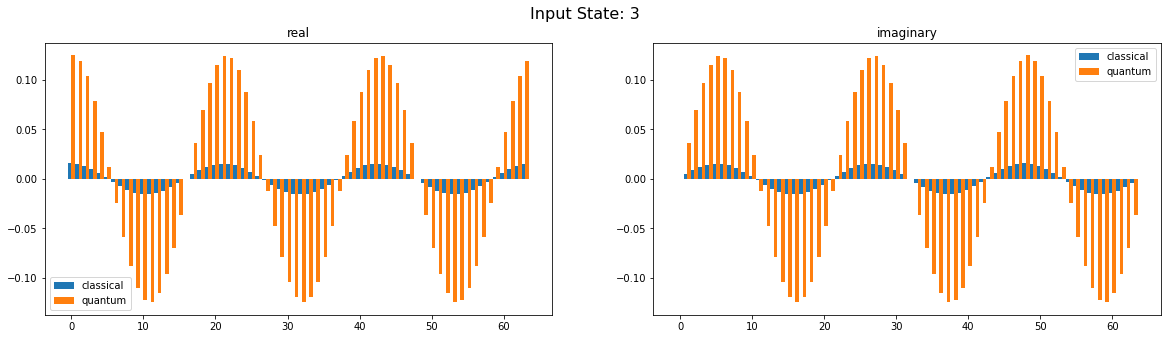

In [3]:
# Plot classical vs. quantum Fourier transform, for all basis states..
# By linearity of Fourier transform, all states map correctly.
# The difference in height is due to normalization in quantum.
for basis_state in [0, 1, 2, 3]:
    state = qi.Statevector.from_int(basis_state, dims=2**num_qubits)
    classical_fourier = np.fft.ifft(state.data)      # classical library function
    quantum_fourier = state.evolve(qft).data         # quantum library (simulation via quantum_info)
    fig = plot_classical_vs_quantum(classical_fourier, quantum_fourier);
    fig.suptitle('Input State: ' + str(basis_state), fontsize=16)

### Example 2: Hartley Transform

<div>
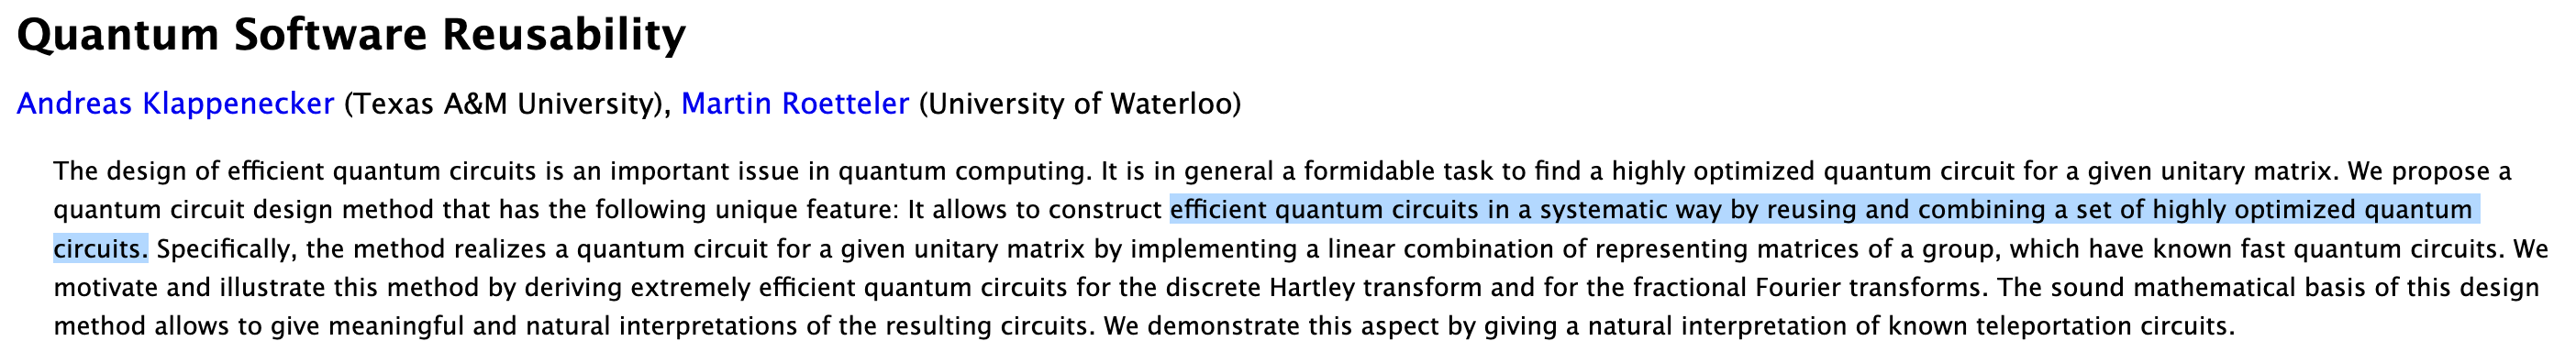
</div>

In [4]:
import numpy as np
import qiskit as qk
import qiskit.quantum_info as qi

num_qubits = 4
h = qk.circuit.library.HGate()                                # grab a Hadamard gate and QFT from circuit library.
qft = qk.circuit.library.QFT(num_qubits).to_gate()
r = qi.Operator(0.5*np.array([[1-1j, 1+1j], [1+1j, 1-1j]]))   # we can also drop a matrix in the circuit.

ctrl = qk.QuantumRegister(1, 'ctrl')
tgt = qk.QuantumRegister(num_qubits, 'x')
qht = qk.QuantumCircuit(tgt, ctrl)

qht = qht.compose(h, ctrl)                                    # start composing circuit from blocks.
qht = qht.compose(qft, tgt)
qht = qht.compose(qft.power(2).control(), [ctrl, *tgt[:]])    # notice ease of raising to power, controlling, etc.
qht = qht.compose(r, ctrl)
qht = qht.compose(qft.power(2).control(), [ctrl, *tgt[:]])    # optimized versions of each block can be used
qht = qht.compose(h, ctrl)                                    # in either the compiler, or backend.

qht.draw(reverse_bits=True)

┌───┐            ┌─────────┐          ┌───┐
ctrl_0: ─┤ H ├──────■─────┤ unitary ├────■─────┤ H ├
        ┌┴───┴─┐┌───┴────┐└─────────┘┌───┴────┐└───┘
   x_3: ┤3     ├┤3       ├───────────┤3       ├─────
        │      ││        │           │        │     
   x_2: ┤2     ├┤2       ├───────────┤2       ├─────
        │  qft ││  qft^2 │           │  qft^2 │     
   x_1: ┤1     ├┤1       ├───────────┤1       ├─────
        │      ││        │           │        │     
   x_0: ┤0     ├┤0       ├───────────┤0       ├─────
        └──────┘└────────┘           └────────┘

### Verify against classical Discrete Hartley Transform

The action of the Hartley transform is:

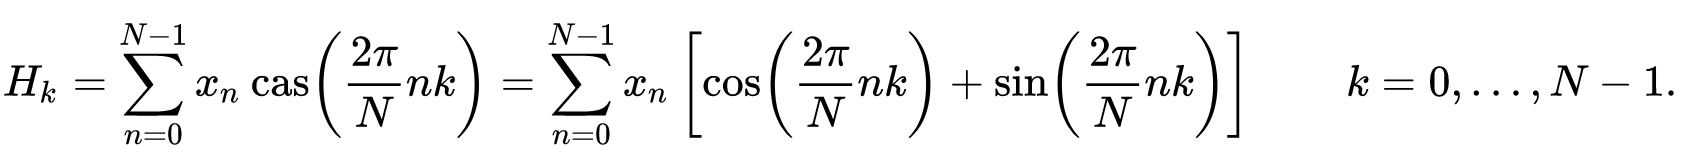

In [5]:
# Classical Hartley Transform

def DHT(x):
    N = x.size
    output = np.zeros(N, dtype=complex)
    for k in range(N):
        transform = 0
        for n in range(N):
            transform += x[n] * (np.cos(2*np.pi*n*k/N) + np.sin(2*np.pi*n*k/N))
        output[k] = transform
    return np.round(output/np.sqrt(N), 2)

In [6]:
# Test some random state with classical and quantum Hartley transform to ensure correctness.
# However Hartley transform maps real-valued functions to real-valued functions.
# Therefore our random state must have real amplitudes.

# 1. quantum_info way
random_state = qi.random_statevector(2**num_qubits)                     # make a Haar random statevector
probs = random_state.probabilities()                                    # convert amplitudes to probabilities
data_state = qi.Statevector(np.sqrt(probs))                             # sqrt(probs) gives real amplitudes
print("random real-amplitude state (option 1)")
print(np.round(data_state.data, 2))

# 2. circuit library way
data_prep_circ = qk.circuit.library.RealAmplitudes(num_qubits)          # this circuit produces only real amps
random_angles = np.random.uniform(0, 2*np.pi, data_prep_circ.num_parameters)  # plug in some random parameters
data_prep_circ.assign_parameters(random_angles, inplace=True)
zero = qi.Statevector.from_int(0, 2**num_qubits)                        # evolve from |0..> to get desired state
data_state = zero.evolve(data_prep_circ)
print("random real-amplitude state (option 2)")
print(np.round(data_state.data, 2))

random real-amplitude state (option 1)
[0.2 +0.j 0.19+0.j 0.28+0.j 0.22+0.j 0.3 +0.j 0.16+0.j 0.14+0.j 0.21+0.j
 0.24+0.j 0.29+0.j 0.24+0.j 0.19+0.j 0.18+0.j 0.39+0.j 0.42+0.j 0.16+0.j]
random real-amplitude state (option 2)
[ 0.14+0.j  0.04+0.j  0.08+0.j  0.05+0.j  0.24+0.j -0.38+0.j -0.27+0.j
 -0.2 +0.j  0.11+0.j -0.25+0.j -0.07+0.j  0.53+0.j  0.19+0.j -0.34+0.j
 -0.13+0.j  0.37+0.j]


In [7]:
# quantum simulation
ancilla_state = qi.Statevector.from_label('0')               # use a clean ancilla
initial_state = ancilla_state.tensor(data_state)             # tensor product of ancilla and target
final_state = initial_state.evolve(qht)                      # evolve state through circuit
reduced_state = qi.partial_trace(final_state, [num_qubits])  # trace out ancilla
quantum_hartley = reduced_state.to_statevector().data        # ancilla was disentangled, get pure statevector

In [8]:
# classical simulation
classical_hartley = DHT(data_state.data)

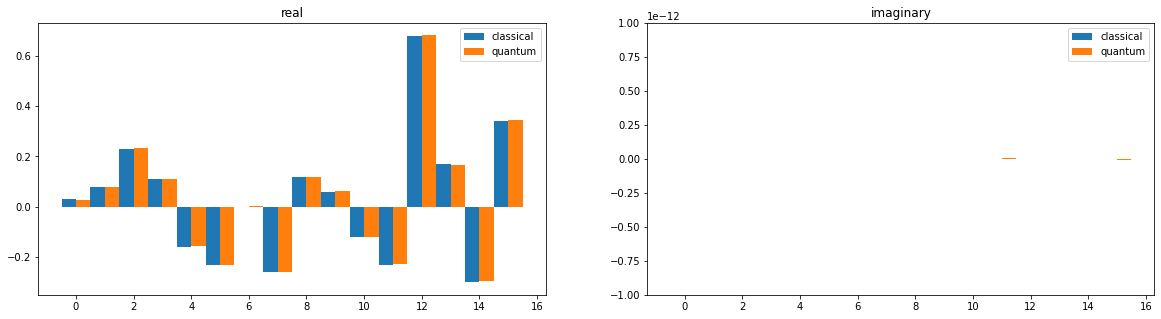

In [9]:
plot_classical_vs_quantum(classical_hartley, quantum_hartley);

### Using circuits in Algorithms

We show how Qiskit's quantum algorithms work natively with the circuit library and how users can explore different ways of performing an algorithm by modifying these circuits.

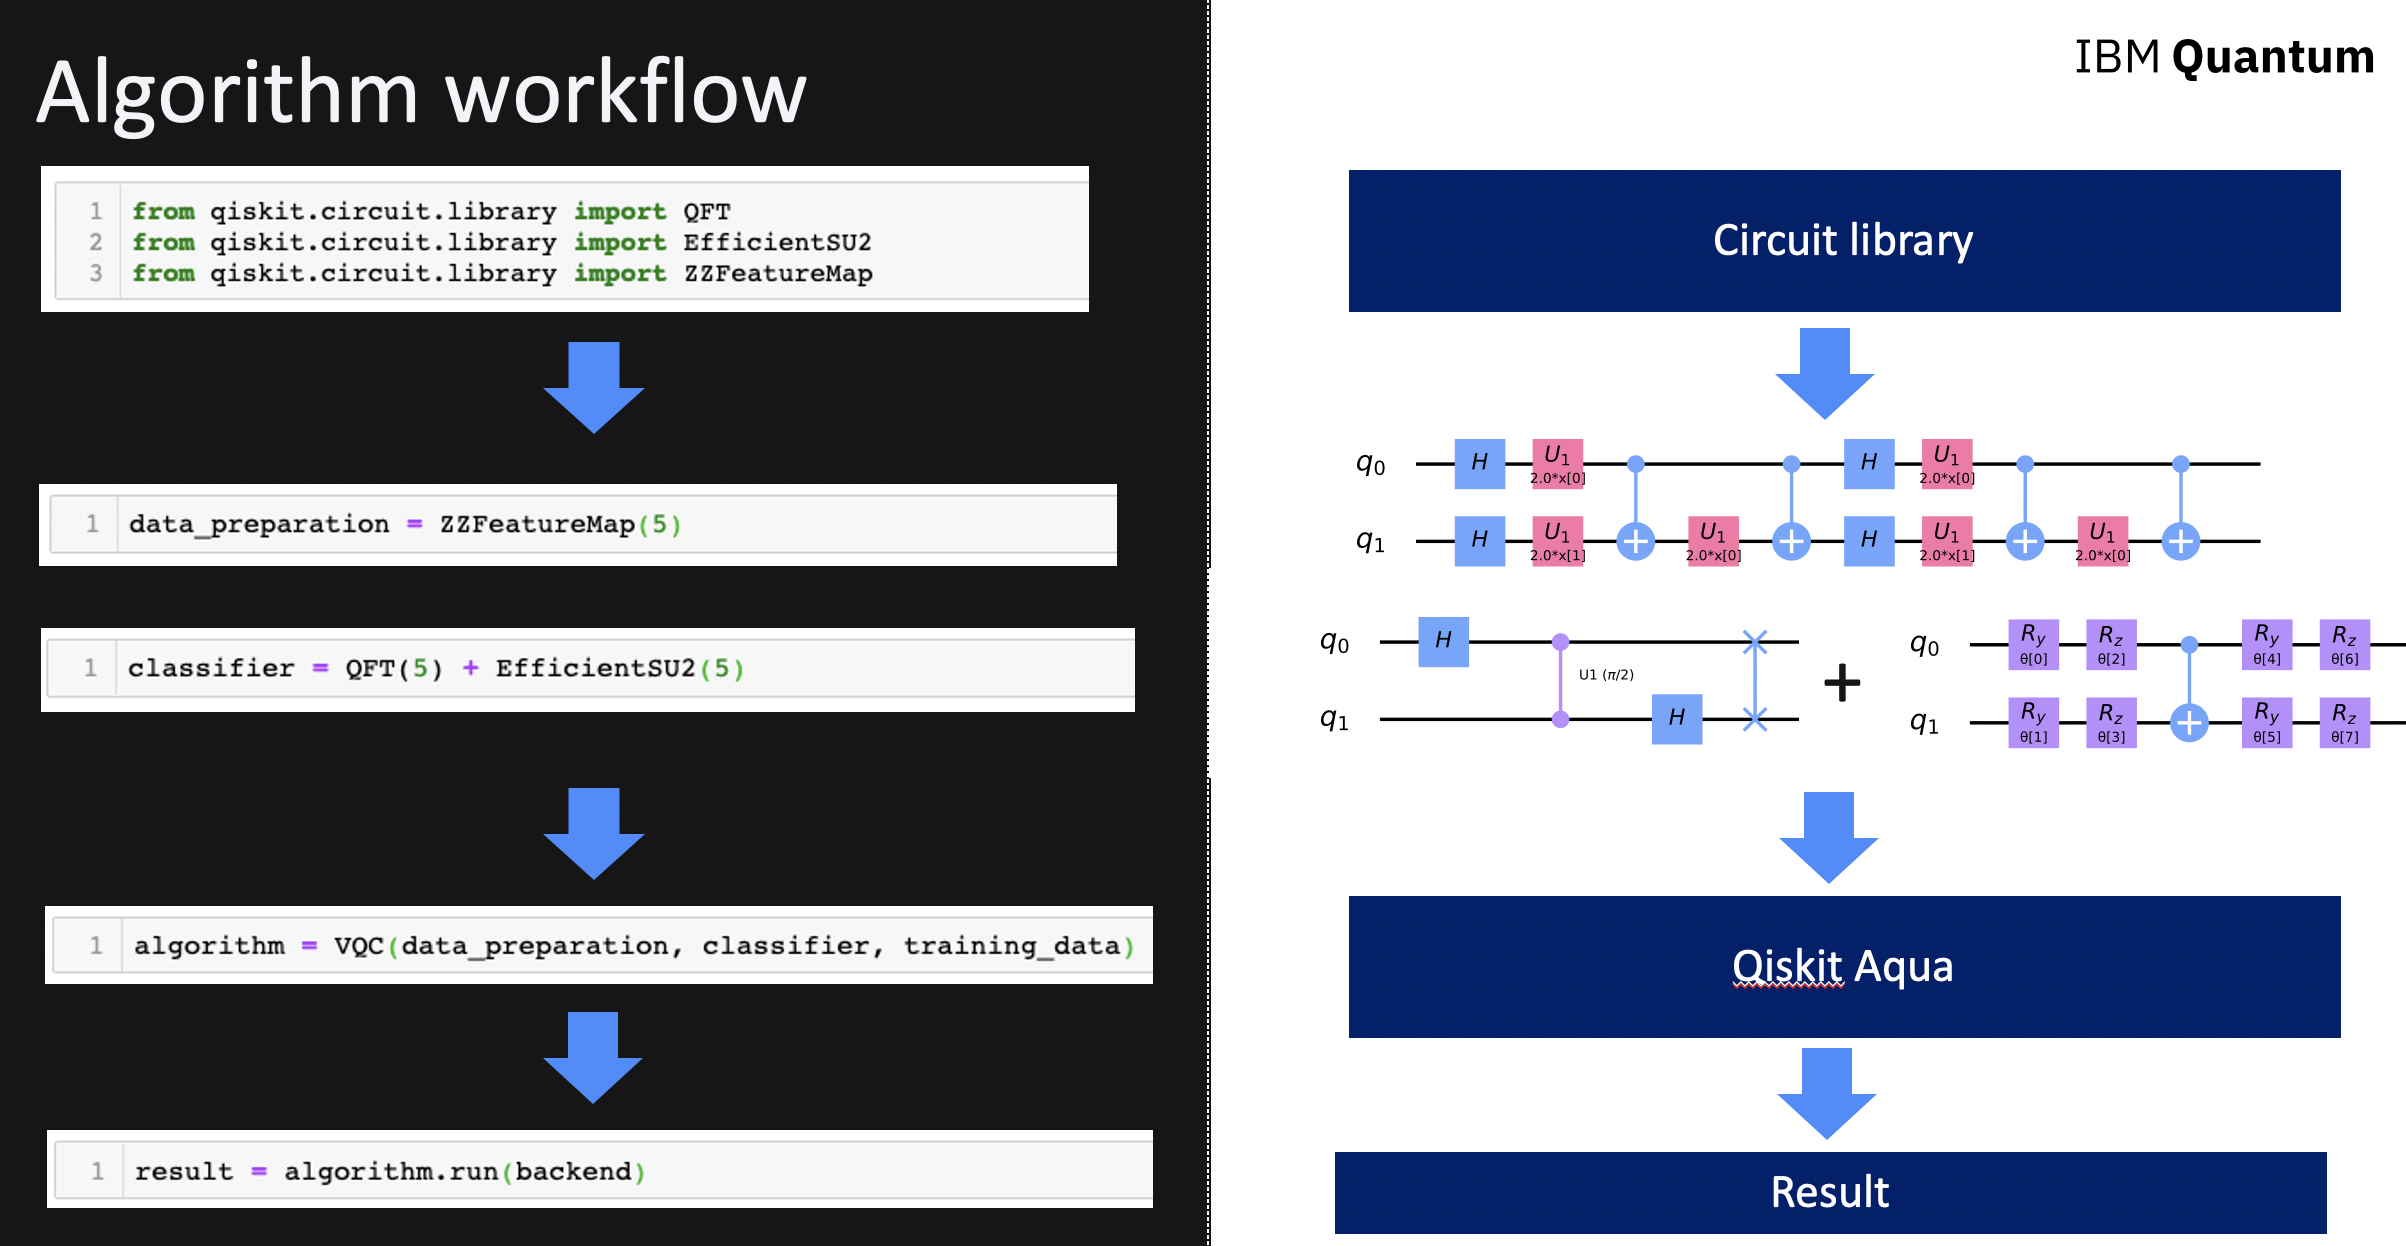

In [1]:
import qiskit
import numpy as np

from qiskit.circuit.library import QFT
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import ZZFeatureMap

In [2]:
training_data = {'A': np.asarray([[2.95309709, 2.51327412], [3.14159265, 4.08407045]]),
                 'B': np.asarray([[4.08407045, 2.26194671], [4.46106157, 2.38761042]])}
testing_data = {'A': np.asarray([[3.83274304, 2.45044227]]),
                'B': np.asarray([[3.89557489, 0.31415927]])}
feature_dimension = 2

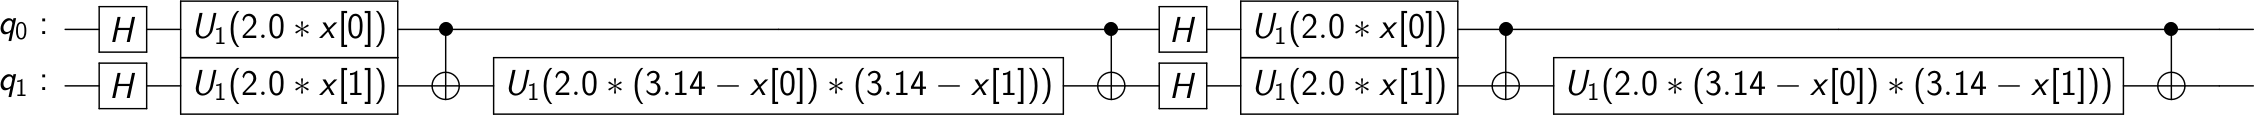

In [3]:
# the algorithm and circuit
from qiskit.aqua.algorithms import VQC

data_preparation = ZZFeatureMap(feature_dimension=feature_dimension, reps=2)
data_preparation.draw('latex', fold=200)

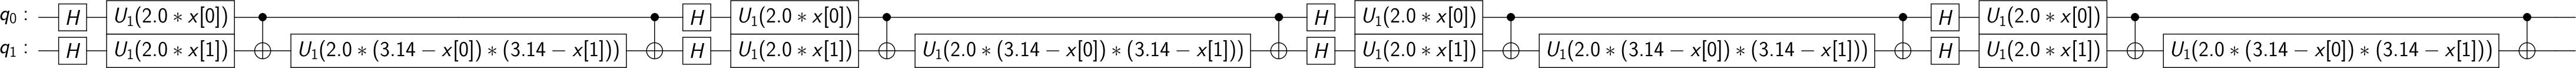

In [4]:
data_preparation.reps = 4
data_preparation.draw('latex', fold=200)

In [5]:
classifier = QFT(2) + EfficientSU2(num_qubits=data_preparation.num_qubits, reps=2)
classifier.draw('text', fold=200)

┌───┐   ┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐
q_0: ──────■─────┤ H ├─X─┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├──■──┤ RY(θ[8]) ├┤ RZ(θ[10]) ├
     ┌───┐ │pi/2 └───┘ │ ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤├───────────┤
q_1: ┤ H ├─■───────────X─┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├┤ X ├┤ RY(θ[9]) ├┤ RZ(θ[11]) ├
     └───┘               └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘└───────────┘

In [6]:
# optimizer for the variational algorithm
from qiskit.aqua.components.optimizers import SLSQP
optimizer = SLSQP()

vqc = VQC(optimizer, data_preparation, classifier, training_data, testing_data)
result = vqc.run(qiskit.providers.aer.QasmSimulator(), seed_simulator=2, seed_transpiler=2)

In [7]:
result

{'num_optimizer_evals': 14,
 'min_val': 0.7708803462825362,
 'opt_params': array([ 0.42085504,  0.64689425, -2.16196901,  0.6935143 , -0.05633642,
        -0.98321653,  1.01709742,  0.4453631 ,  0.26390389, -0.84370511,
         1.63060349, -0.52706969]),
 'eval_time': 1.0560622215270996,
 'eval_count': 14,
 'training_loss': 0.7708803462825362,
 'testing_accuracy': 0.5,
 'test_success_ratio': 0.5,
 'testing_loss': 0.7095179328057665}

### Quantum Volume (Random permutations + Haar-Random SU(4))
(https://arxiv.org/pdf/1811.12926.pdf)

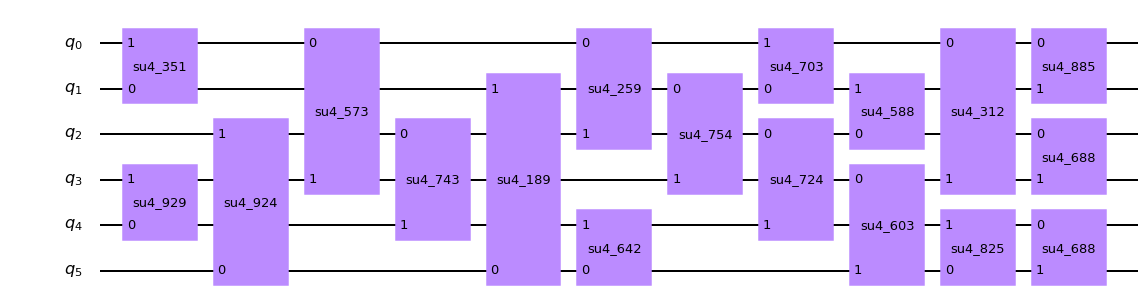

In [8]:
from qiskit.circuit.library import QuantumVolume
circ = QuantumVolume(num_qubits=6, depth=6)
circ.decompose().draw('mpl', fold=100)

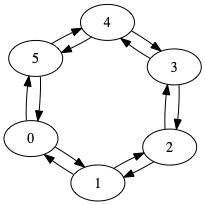

In [9]:
from qiskit.transpiler import CouplingMap
cmap = CouplingMap.from_ring(6)
cmap.draw()

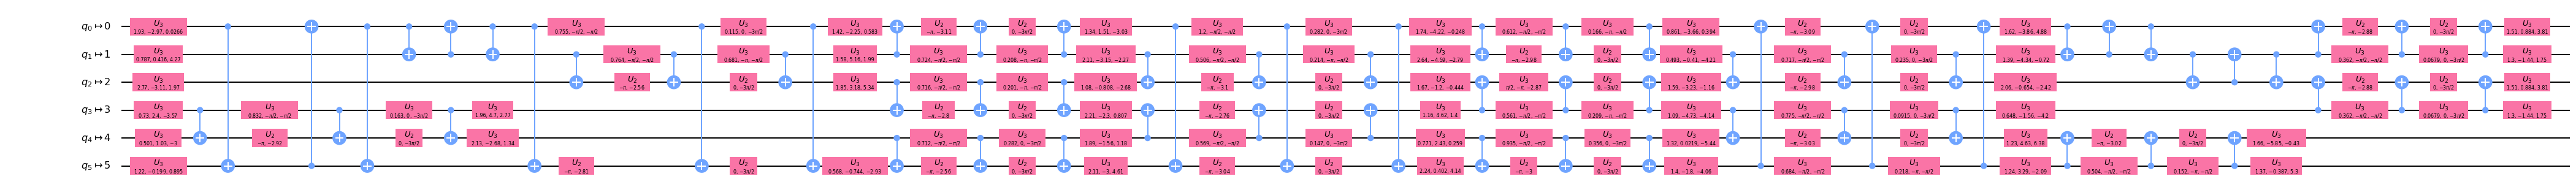

In [10]:
from qiskit import transpile
new_circ = transpile(circ, coupling_map=cmap, basis_gates=['u1', 'u2', 'u3', 'cx'],
                     layout_method='trivial', routing_method='stochastic', optimization_level=3)
new_circ.draw('mpl', fold=100)

In [11]:
print(new_circ.depth(), new_circ.num_nonlocal_gates())

49 66


### Fourier Checking

In [12]:
import qiskit.quantum_info as qi
from qiskit.circuit.library import FourierChecking
from qiskit.visualization import plot_histogram

f = [1, -1, -1, -1]
g = [1, 1, -1, -1]
circ = FourierChecking(f=f, g=g)   # Oracles represented as diagonal operators. Working on more efficient ways.
circ.draw()

┌───┐┌───────────────────────┐┌───┐┌──────────────────────┐┌───┐
q_0: ┤ H ├┤0                      ├┤ H ├┤0                     ├┤ H ├
     ├───┤│  DIAGONAL(1,-1,-1,-1) │├───┤│  DIAGONAL(1,1,-1,-1) │├───┤
q_1: ┤ H ├┤1                      ├┤ H ├┤1                     ├┤ H ├
     └───┘└───────────────────────┘└───┘└──────────────────────┘└───┘

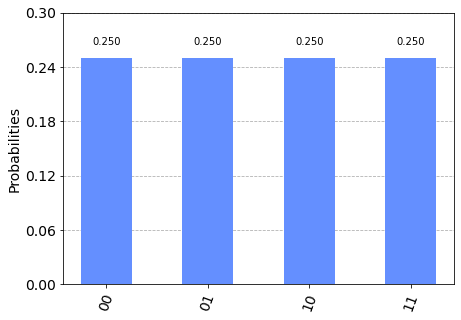

In [13]:
zero = qi.Statevector.from_label('00')
sv = zero.evolve(circ)
probs = sv.probabilities_dict()
plot_histogram(probs)

## Graph states

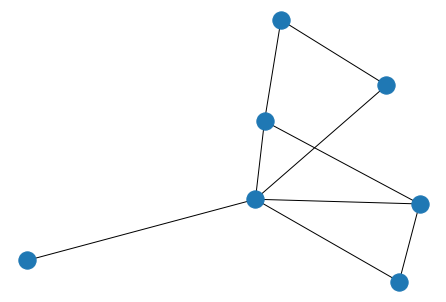

In [14]:
from qiskit.circuit.library import GraphState
import qiskit.tools.jupyter
import networkx as nx
import numpy as np

G = nx.Graph()
G.add_edges_from([(1, 2), (1,3), (1,4), (3, 4), (4, 5), (5,2), (6,1), (6,3), (9,1)])
adjmat = nx.adjacency_matrix(G)
nx.draw(G)

In [15]:
mat = adjmat.toarray()
circuit = GraphState(mat)       # circuit parameterized by a matrix.
%circuit_library_info circuit   # pretty printer for circuit library.

In [16]:
# get its stabalizers
from qiskit.quantum_info import Clifford
Clifford(circuit).to_dict()

{'stabilizer': ['+ZZIZZZX',
  '+IIZIIXZ',
  '+IZIZXIZ',
  '+IIZXZIZ',
  '+IIXZIZI',
  '+IXIIZIZ',
  '+XIIIIIZ'],
 'destabilizer': ['+IIIIIIZ',
  '+IIIIIZI',
  '+IIIIZII',
  '+IIIZIII',
  '+IIZIIII',
  '+IZIIIII',
  '+ZIIIIII']}